In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
TDC = pd.read_csv('./JustTaxiAnalytics.csv')

In [3]:
TDC.head(10)

booking_id  accuracy     bearing  acceleration_x  acceleration_y  \
0   309237645396     3.900  298.000000       -0.373673        9.287003   
1   635655159839    10.000  105.063110        0.095554       -7.256091   
2    68719476855     3.900  160.000000        0.493000        9.450000   
3   214748364930     3.000  226.000000        0.424061        9.005522   
4     8589934651     3.900  177.000000        0.471390        9.011368   
5  1168231104535    32.000  117.145905       -1.218420       -9.336139   
6  1348619730957     5.000  273.033050       -0.319110       -9.194529   
7  1116691497111     4.000  111.000000       -0.495615        8.408693   
8     8589934706     3.972  259.000000       -0.548035        7.992035   
9   283467841694     9.000   47.248993       -0.250623       -9.817795   

   acceleration_z    gyro_x    gyro_y    gyro_z  second  ...  acceleration  \
0        3.450790  0.019684 -0.008652 -0.000122     4.0  ...      4.115000   
1       -5.868097 -0.041447 -0.126973 -0.034965   642.0  ...      0.027399   
2        0.375000 -0.031586 -0.482635  0.075562   224.0  ...      0.108930   
3       -3.281991  0.039916  0.004747  0.018937  1008.0  ...      0.000000   
4        2.549545 -0.011719 -0.116433  0.024612  1035.0  ...      0.019140   
5       -1.249374 -0.082649 -0.237613 -0.062716   599.0  ...      0.016190   
6       -0.927722  0.054250 -0.003099  0.012686   190.0  ...      0.018502   
7        4.812492  0.009930 -0.053581  0.003511  1284.0  ...      0.020764   
8        7.287231  0.271179  0.309525  0.028885   330.0  ...      0.004727   
9       -1.419397  0.036415 -0.017237 -0.030254   651.0  ...      0.000035   

   driver_id  label     name  date_of_birth  gender   car_model  \
0         58      0    Robbi     1977-10-29    Male        Ford   
1        140      0   Murvyn     1987-05-13    Male      Toyota   
2        130      0    Taryn     1980-04-25    Male      Nissan   
3         80      0   Gerald     1976-01-11    Male  Volkswagen   
4        147      0   Delila     1982-11-08  Female      Toyota   
5         65      0  Tabatha     1976-08-10    Male      Nissan   
6         69      0    Ozzie     1984-09-30    Male     Hyundai   
7        118      0     Rana     1973-09-06    Male      Nissan   
8        133      0    Sonia     1978-05-01  Female  Volkswagen   
9          6      1    Tyrus     1983-10-20    Male        Ford   

   car_make_year  rating age  
0           2011     3.5  45  
1           2011     4.0  35  
2           2011     4.5  42  
3           2005     4.5  46  
4           2011     3.0  40  
5           2011     3.5  46  
6           2009     4.5  38  
7           2010     4.5  49  
8           2011     4.5  44  
9           2013     4.5  39  

[10 rows x 26 columns]

In [4]:
TDC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7467388 entries, 0 to 7467387
Data columns (total 26 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   accuracy        float64
 2   bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  speed (km/h)    float64
 12  yaw             float64
 13  pitch           float64
 14  roll            float64
 15  turning_force   float64
 16  acceleration    float64
 17  driver_id       int64  
 18  label           int64  
 19  name            object 
 20  date_of_birth   object 
 21  gender          object 
 22  car_model       object 
 23  car_make_year   int64  
 24  rating          float64
 25  age             int64  
dtypes: float64(17), int64(5), object(4)
memory usage: 1.4+ GB


## EDA & Feature Importance

### Correlation Matrix

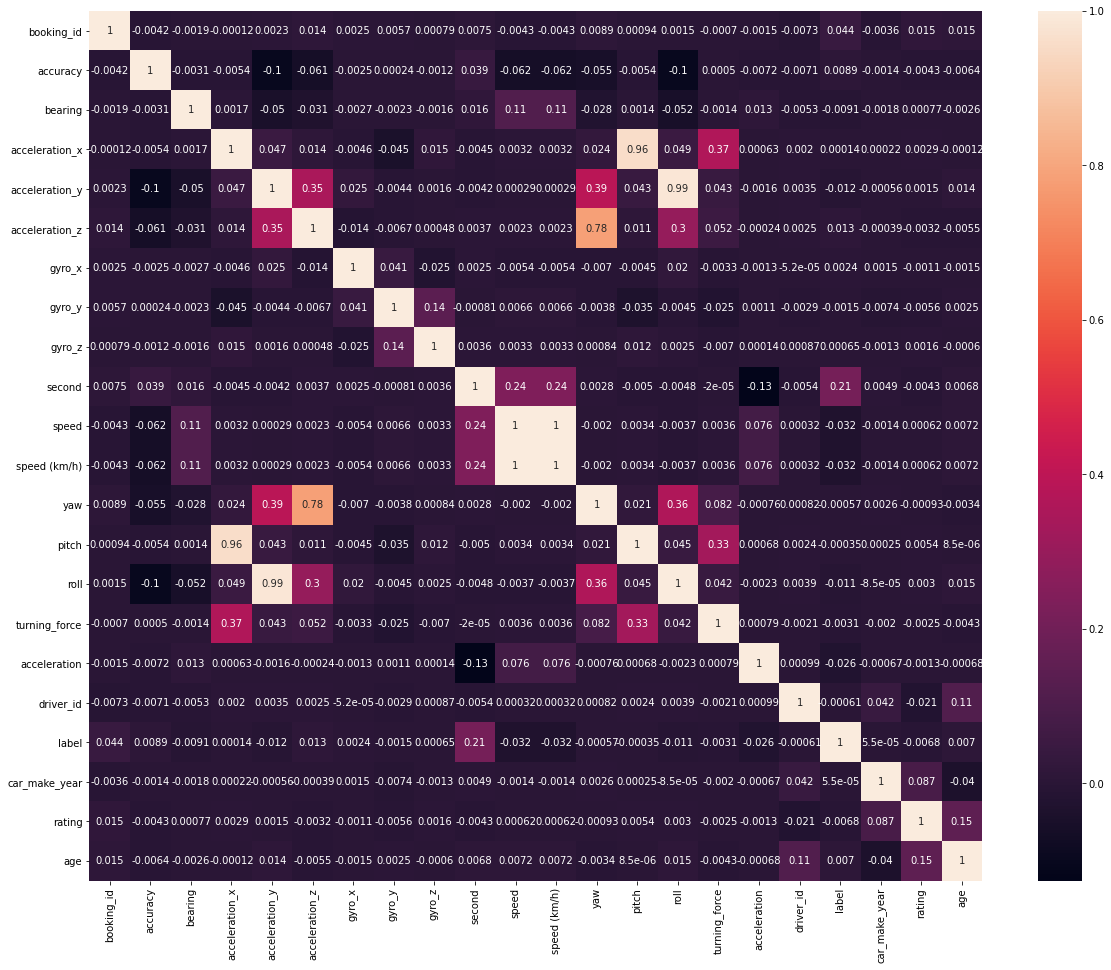

In [5]:
corrMatrix = TDC.corr()
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Pairplot

In [6]:
readings_cols = TDC.columns.difference(["booking_id", "second"])

<Figure size 1440x1440 with 0 Axes>

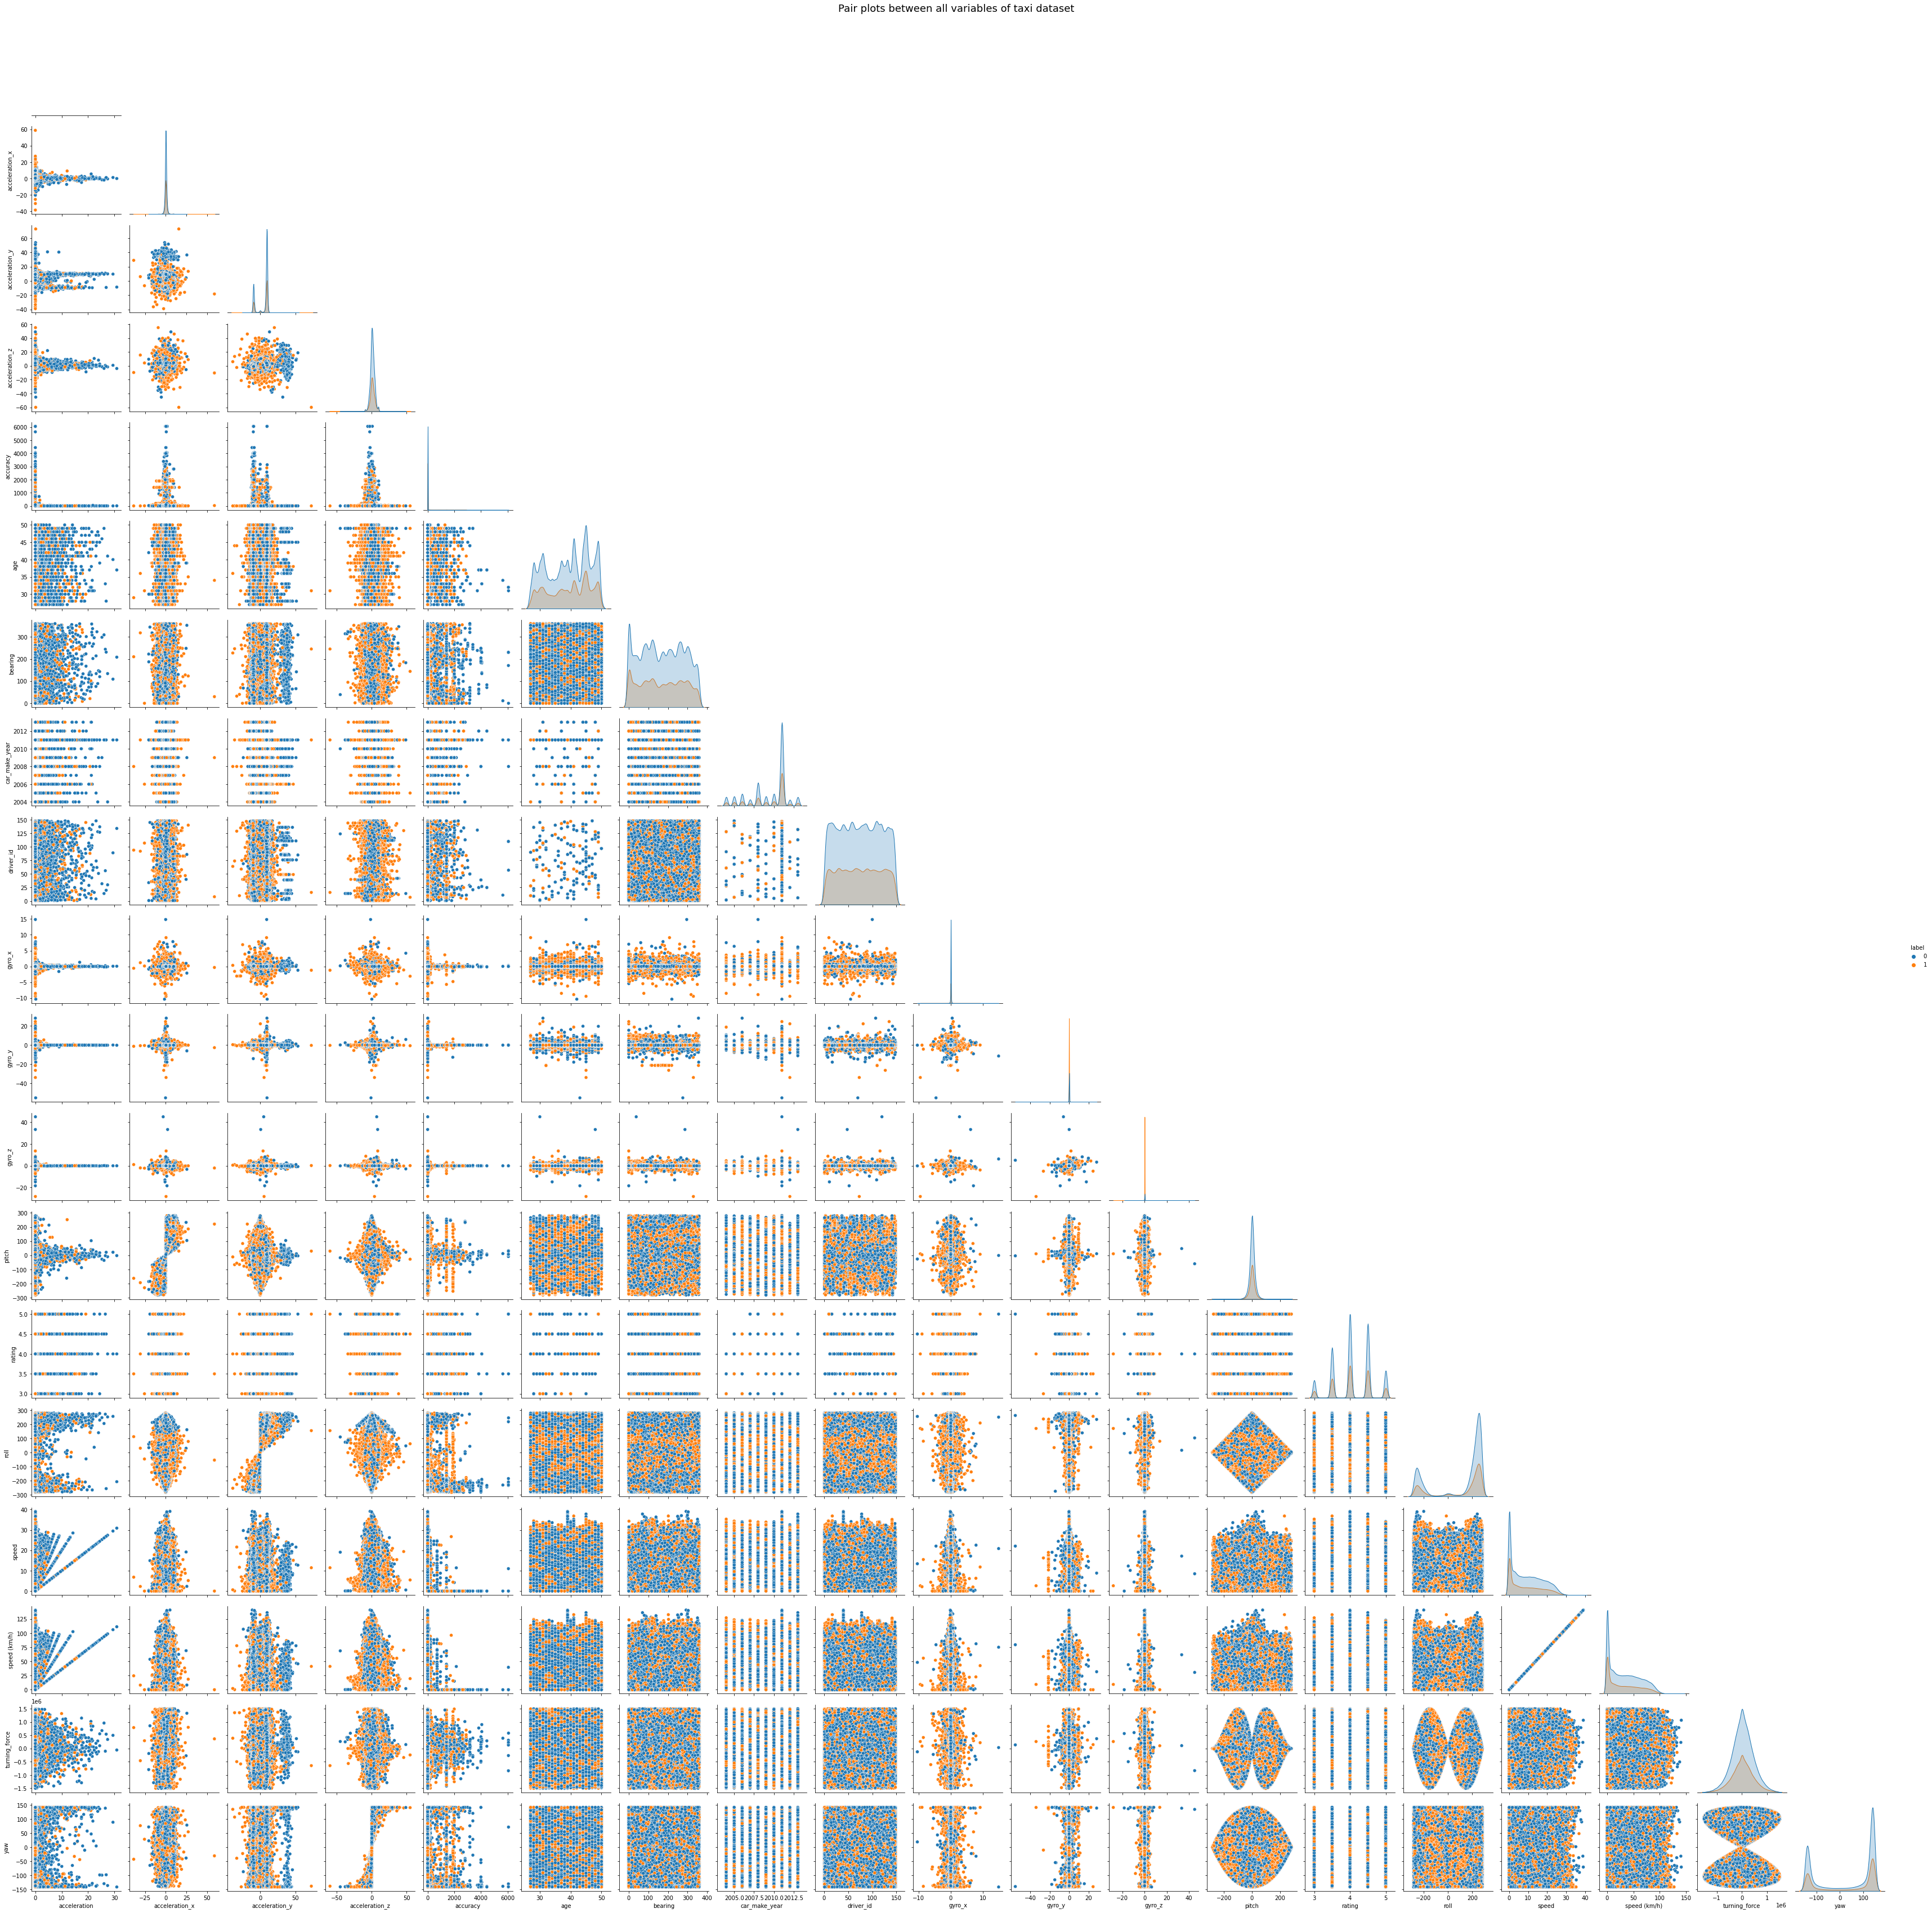

In [8]:
fig = plt.figure(figsize=(20,20))
g = sns.pairplot(
    TDC.sample(700000).loc[:, readings_cols],
    corner=True,
    diag_kind="kde",
    hue="label"
)
g.fig.suptitle("Pair plots between all variables of taxi dataset", y=1.001, fontsize=18)
plt.show()


## Feature Enineering

### Calculating G-Force

In [5]:
TDC['G-Force'] = TDC.apply(lambda row: row['acceleration'] / 9.8, axis=1)

The apply() method is used to apply a lambda function to each row of the DataFrame TDC. The lambda function accepts a row and returns the value row['acceleration'] / 9.8. This determined value is 'G-Force' in the DataFrame.

In [6]:
TDC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7467388 entries, 0 to 7467387
Data columns (total 27 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   accuracy        float64
 2   bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  speed (km/h)    float64
 12  yaw             float64
 13  pitch           float64
 14  roll            float64
 15  turning_force   float64
 16  acceleration    float64
 17  driver_id       int64  
 18  label           int64  
 19  name            object 
 20  date_of_birth   object 
 21  gender          object 
 22  car_model       object 
 23  car_make_year   int64  
 24  rating          float64
 25  age             int64  
 26  G-Force         float64
dtypes: float64(18), int64(5), object(4)
memor

In [7]:
TDC['G-Force']

0          0.419898
1          0.002796
2          0.011115
3          0.000000
4          0.001953
             ...   
7467383    0.010392
7467384    0.001291
7467385    0.001495
7467386    0.000391
7467387    0.009282
Name: G-Force, Length: 7467388, dtype: float64

In [8]:
TDC = TDC.drop(TDC[TDC['G-Force'] > 3].index)

The indices of the rows that fulfill this criterion are supplied to the drop() method, which are obtained using the following line: index TDC[TDC['G-Force'] > 3]. This removes any entries from the DataFrame if the g-force is more than 3g.

In [9]:
TDC['G-Force']

0          0.419898
1          0.002796
2          0.011115
3          0.000000
4          0.001953
             ...   
7467383    0.010392
7467384    0.001291
7467385    0.001495
7467386    0.000391
7467387    0.009282
Name: G-Force, Length: 7460619, dtype: float64

## Feature Selection

In [10]:
TDC.shape

(7460619, 27)

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Specifying the non-categorical columns
X_col = ["accuracy","bearing","acceleration_x","acceleration_y","acceleration_z","gyro_x","gyro_y","gyro_z","second","speed",
         "speed (km/h)","yaw","pitch","roll","turning_force","acceleration","rating","G-Force",]

# Creating the Decision Tree Classifier Model
model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
class_weight=None, ccp_alpha=0.0)

# Load the dataset without the categorical features
X = TDC.drop(['label','booking_id','name','date_of_birth','gender','car_model','car_make_year','age','driver_id'], axis=1)
y = TDC.label

# Fit the model to the data
model.fit(X,y)

DecisionTreeClassifier()

To generate a decision tree model, we use the DecisionTreeClassifier class from the sklearn.tree package and specifing the model's parameters such as 'criterion,"splitter,"max depth,' and so on.

We then select features to be utilized for training the model by eliminating the categorical columns such as 'label,"booking id,"name,"date of birth,"gender,'car model,'car make year,"age,"driver id'. The variable X holds the remaining columns. The variable y stores the column label.

Finally, we use fit to train the model using the data.

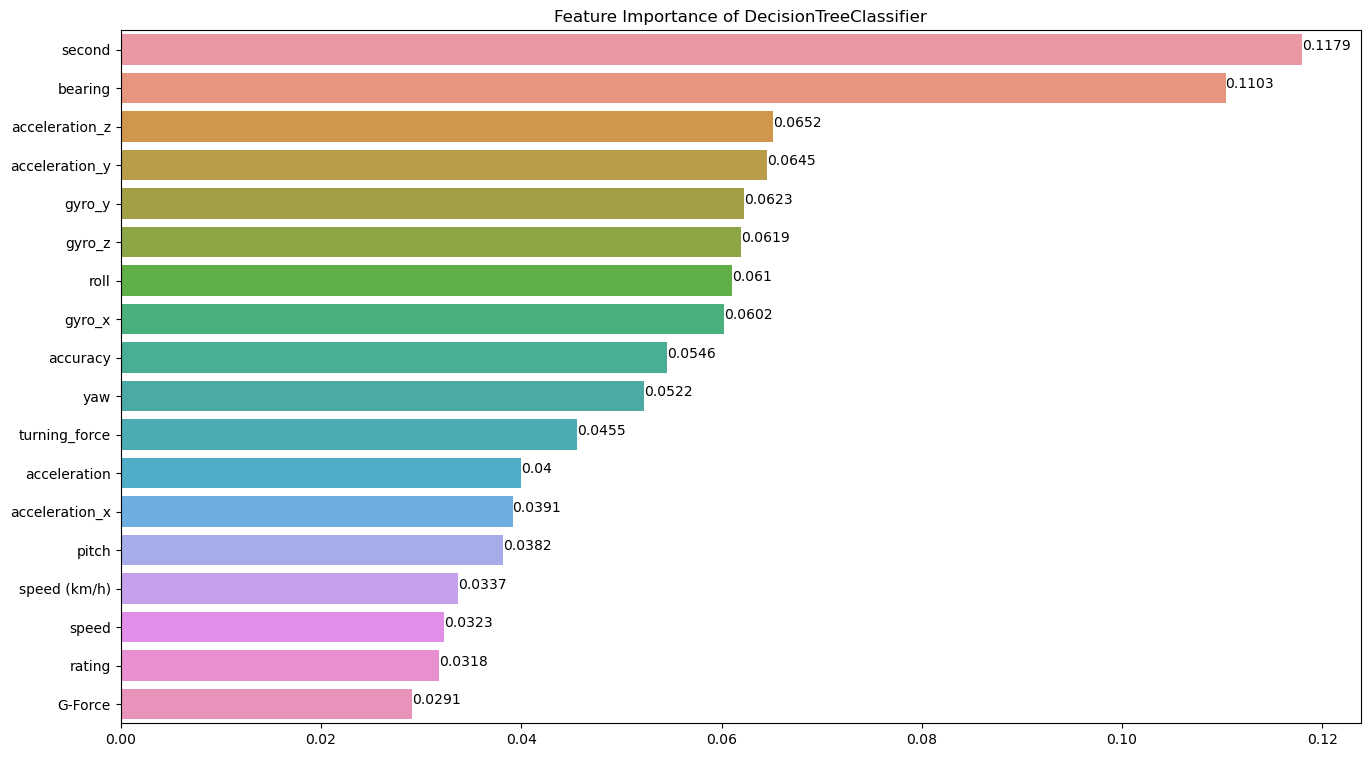

In [12]:
importance = pd.Series(
    model.feature_importances_, index=X_col
).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    x=importance[importance > 0].values, y=importance[importance > 0].index, ax=ax
)
ax.set_title("Feature Importance of {}".format("DecisionTreeClassifier"))
[
    ax.text(x=v, y=i, s=round(v, 4))
    for i, v in zip(np.arange(0, len(importance)), importance[importance > 0].values)
]
plt.show()

We now want to illustrate the feature significance of the previously trained decision tree model. It begins by significance, which keeps the decision tree model's feature importances in the model. The feature importances_ property is used, and the column names are assigned to the series using the X col variable. After that, the feature importance values are sorted in descending order.

The sns.barplot() method is used to generate a bar plot, with the x-axis representing feature significance levels and the y-axis representing feature names.

In [13]:
TDC = TDC.drop(['speed','date_of_birth','gender','car_model','car_make_year','age','name','rating','driver_id','G-Force'], axis=1)
TDC.head()

booking_id  accuracy    bearing  acceleration_x  acceleration_y  \
0  309237645396       3.9  298.00000       -0.373673        9.287003   
1  635655159839      10.0  105.06311        0.095554       -7.256091   
2   68719476855       3.9  160.00000        0.493000        9.450000   
3  214748364930       3.0  226.00000        0.424061        9.005522   
4    8589934651       3.9  177.00000        0.471390        9.011368   

   acceleration_z    gyro_x    gyro_y    gyro_z  second  speed (km/h)  \
0        3.450790  0.019684 -0.008652 -0.000122     4.0     59.255997   
1       -5.868097 -0.041447 -0.126973 -0.034965   642.0     63.323997   
2        0.375000 -0.031586 -0.482635  0.075562   224.0     87.841470   
3       -3.281991  0.039916  0.004747  0.018937  1008.0      0.000000   
4        2.549545 -0.011719 -0.116433  0.024612  1035.0     71.315994   

         yaw     pitch       roll  turning_force  acceleration  label  
0  140.84708 -6.785761  218.36288    -208701.330      4.115000      0  
1 -141.35974  1.843027 -160.32603      41769.707      0.027399      0  
2   97.98992  9.374606  270.96182     248910.120      0.108930      0  
3 -140.62660  7.958456  219.35558    -245496.300      0.000000      0  
4  139.85912  9.052619  232.31567     294132.840      0.019140      0

In [14]:
TDC.shape

(7460619, 17)

### Data Aggregation

In [15]:
# Custom function for measure of dispersion
def standard_deviation():
    def standard_deviation_(x):
        return np.std(x, ddof=0)
    standard_deviation_.__name__ = 'std'
    return standard_deviation_

# Custom function to calculate Q1 and Q3
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Aggregate by bookingid (As 1 booking has many seconds)
TDCAG = pd.DataFrame()
for col in tqdm(TDC.columns):
    if col != "booking_id" and col != "label":
        temp = TDC.groupby("booking_id")[col].agg(["mean", 'max', 'min', standard_deviation(), percentile(25), percentile(75)])
        TDCAG[col + "_mean"] = temp["mean"]
        TDCAG[col + "_max"] = temp["max"]
        TDCAG[col + "_min"] = temp["min"]
        TDCAG[col+ "_std"] = temp['std']
        TDCAG[col + "_25%"] = temp['percentile_25']
        TDCAG[col + "_75%"] = temp['percentile_75']
    elif col == "label":
        temp = TDC.groupby("booking_id")[col].agg(["max"])
        TDCAG[col] = temp['max']

# Display dataframe
TDCAG.reset_index(inplace=True)
display(TDCAG)

# Display dataframe shape
print("Before Aggregation: {}".format(TDC.shape))
print("After Aggregation: {}".format(TDCAG.shape))

  0%|          | 0/17 [00:00<?, ?it/s]

booking_id  accuracy_mean  accuracy_max  accuracy_min  accuracy_std  \
0                  0       9.855411        48.000         4.000      3.961431   
1                  1       3.922742        84.450         3.000      4.104310   
2                  2       3.818223         8.000         3.000      1.089036   
3                  4       9.953348        11.000         4.069      0.481017   
4                  6       4.623058        12.000         3.000      1.365257   
...              ...            ...           ...           ...           ...   
19985  1709396983957       4.167014        43.317         3.000      3.696966   
19986  1709396983960      11.774484        25.000         3.450      3.996904   
19987  1709396983966       9.321048        12.597         3.500      1.351355   
19988  1709396983971       5.177610        48.000         3.000      4.297179   
19989  1709396983975      33.058444       200.000         3.328     49.090833   

       accuracy_25%  accuracy_75%  bearing_mean  bearing_max  bearing_min  \
0             8.000      12.00000    176.745606    359.97977     0.037464   
1             3.000       4.00000    127.311267    337.00000     0.000000   
2             3.000       3.95000    183.765060    330.00000    11.000000   
3            10.000      10.00000    149.783870    351.40985     2.271227   
4             3.900       4.94575    194.469008    346.00000     0.000000   
...             ...           ...           ...          ...          ...   
19985         3.000       3.90000    169.295927    359.00000     0.000000   
19986         8.000      16.00000    177.654317    348.47974    10.027151   
19987         9.648       9.64800    196.285054    359.00000     0.000000   
19988         3.900       6.00000    205.918083    358.00000     1.000000   
19989         6.000      32.00000    103.314329    355.80084     4.092619   

       ...  turning_force_std  turning_force_25%  turning_force_75%  \
0      ...      425243.970106       -545810.0650       -22569.36225   
1      ...      344555.457697        129148.6675       486373.53500   
2      ...      348493.922292       -103351.1050       335794.77000   
3      ...      303380.890713       -334010.3050       -63452.88125   
4      ...      359611.049924         83473.2410       454093.61000   
...    ...                ...                ...                ...   
19985  ...      381178.343772       -101615.1250       102161.04000   
19986  ...      363757.584356        159103.1900       452054.54500   
19987  ...      390942.540930       -326044.8000       106241.47000   
19988  ...      495246.454901        -99044.6300       768966.30000   
19989  ...      267621.299264       -272893.6550       -35981.67600   

       acceleration_mean  acceleration_max  acceleration_min  \
0               0.012712          0.137985               0.0   
1               0.032536          1.839744               0.0   
2               0.056233          0.514143               0.0   
3               0.036966          5.170000               0.0   
4               0.064067          9.454126               0.0   
...                  ...               ...               ...   
19985           0.019120          2.142207               0.0   
19986           0.037715          2.971887               0.0   
19987           0.029680          0.484181               0.0   
19988           0.021496          3.758333               0.0   
19989           0.018331          0.088951               0.0   

       acceleration_std  acceleration_25%  acceleration_75%  label  
0              0.021438          0.004115          0.012772      0  
1              0.138877          0.000000          0.022038      1  
2              0.092621          0.000000          0.093323      1  
3              0.258846          0.005585          0.020596      1  
4              0.521633          0.000000          0.015677      0  
...                 ...               ...               ...    ...  
19985  

Before Aggregation: (7460619, 17)
After Aggregation: (19990, 92)


We first define two custom functions: one for calculating a given dataset's standard deviation and another for computing a specified percentile (e.g., Q1 or Q3) of a dataset. 

These routines are then used to aggregate the TDC dataset using the "booking id" column. TDCAG, the resultant aggregated dataset, contains columns for the mean, maximum, minimum, standard deviation, 25th percentile, and 75th percentile of each TDC characteristic, as well as the maximum value of the "label" column for each "booking id" group.

In [16]:
TDCAG = TDCAG.drop(['booking_id'], axis=1)
TDCAG.head()

accuracy_mean  accuracy_max  accuracy_min  accuracy_std  accuracy_25%  \
0       9.855411         48.00         4.000      3.961431           8.0   
1       3.922742         84.45         3.000      4.104310           3.0   
2       3.818223          8.00         3.000      1.089036           3.0   
3       9.953348         11.00         4.069      0.481017          10.0   
4       4.623058         12.00         3.000      1.365257           3.9   

   accuracy_75%  bearing_mean  bearing_max  bearing_min  bearing_std  ...  \
0      12.00000    176.745606    359.97977     0.037464   129.792149  ...   
1       4.00000    127.311267    337.00000     0.000000    89.155252  ...   
2       3.95000    183.765060    330.00000    11.000000   113.946810  ...   
3      10.00000    149.783870    351.40985     2.271227    69.559743  ...   
4       4.94575    194.469008    346.00000     0.000000   114.599572  ...   

   turning_force_std  turning_force_25%  turning_force_75%  acceleration_mean  \
0      425243.970106       -545810.0650       -22569.36225           0.012712   
1      344555.457697        129148.6675       486373.53500           0.032536   
2      348493.922292       -103351.1050       335794.77000           0.056233   
3      303380.890713       -334010.3050       -63452.88125           0.036966   
4      359611.049924         83473.2410       454093.61000           0.064067   

   acceleration_max  acceleration_min  acceleration_std  acceleration_25%  \
0          0.137985               0.0          0.021438          0.004115   
1          1.839744               0.0          0.138877          0.000000   
2          0.514143               0.0          0.092621          0.000000   
3          5.170000               0.0          0.258846          0.005585   
4          9.454126               0.0          0.521633          0.000000   

   acceleration_75%  label  
0          0.012772      0  
1          0.022038      1  
2          0.093323      1  
3          0.020596      1  
4          0.015677      0  

[5 rows x 91 columns]

In [17]:
TDCAG.to_csv("TaxiDatasetAgg.csv", index=False)

### Visualising Outliers

In [ ]:
X = TDCAG.drop(['label'], axis=1)
y = TDCAG.label

In [ ]:
classifier_dict = {"One-Class SVM": OneClassSVM(nu=0.05),
                   "Isolation Forest": IsolationForest(contamination=0.05),
                   "Cluster-based LOF": LocalOutlierFactor(contamination=0.05)}
Outliers = TDC
for i, (clf_name, clf) in enumerate(classifier_dict.items()):
    clf.fit(X)
    X["anomaly"] = clf.fit_predict(X)
    outliers_subset = X[X.anomaly == -1]
    outliers_subset = outliers_subset.assign(model = clf_name)
    Outliers = pd.concat([Outliers, outliers_subset], axis=0, ignore_index=False)

pca = PCA(n_components=3) # reduce to k=3 dimensions
scaler = StandardScaler()
XT = scaler.fit_transform(X)
X_reduce = pca.fit_transform(XT)
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection="3d")
ax.set_zlabel("x_composite_3")
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=30, lw=1, label="inliers",c="green")
ax.scatter(X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 0],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 1],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 2],
           lw=4, s=40, c="red", label="One Class SVM")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 2],
           lw=4, s=40, marker='x', c="blue", label="Isolation Forest")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 2],
           lw=4, s=50, c="orange", label="Cluster-based LOF")
plt.title("Anomaly Detection for Dataset", fontsize=20)
plt.legend()
plt.tight_layout()

### Model Performance Before Outlier Detection

In [19]:
import dask
import dask.dataframe as dd
from sklearn.utils import parallel_backend
from dask.distributed import Client


client = Client()

scoring = {
    'precision': 'precision',
    'roc_auc': 'roc_auc',
    'F1': 'f1'
}

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

lr_model = LogisticRegression(max_iter=50000)
with parallel_backend('dask'):
    lr_model.fit(X_train,y_train)
    y_pred_lr = lr_model.predict(X_test)

gbc_model = GradientBoostingClassifier(n_estimators = 50)
with parallel_backend('dask'):
    gbc_model.fit(X_train, y_train)
    y_pred_gbc = gbc_model.predict(X_test)

cv_results_lr = cross_validate(lr_model, X_train, y_train, cv=5, scoring=scoring)
cv_results_gbc = cross_validate(gbc_model, X_train, y_train, cv=5, scoring=scoring)

summary = pd.DataFrame([[cv_results_lr['fit_time'].mean(), cv_results_lr['test_F1'].mean(), cv_results_lr['test_precision'].mean(), cv_results_lr['test_roc_auc'].mean()],
                        [cv_results_gbc['fit_time'].mean(), cv_results_gbc['test_F1'].mean(), cv_results_gbc['test_precision'].mean(), cv_results_gbc['test_roc_auc'].mean()]],
                        columns=['Mean Fit Time', 'Mean F1 Score', 'Mean Precision', 'Mean ROC AUC'], index=['Logistic Regression', 'Gradient Boosting Classifier'])
display(summary.round(2))

Mean Fit Time  Mean F1 Score  Mean Precision  \
Logistic Regression                    0.08           0.00            0.00   
Gradient Boosting Classifier          20.74           0.32            0.72   

                              Mean ROC AUC  
Logistic Regression                   0.48  
Gradient Boosting Classifier          0.74

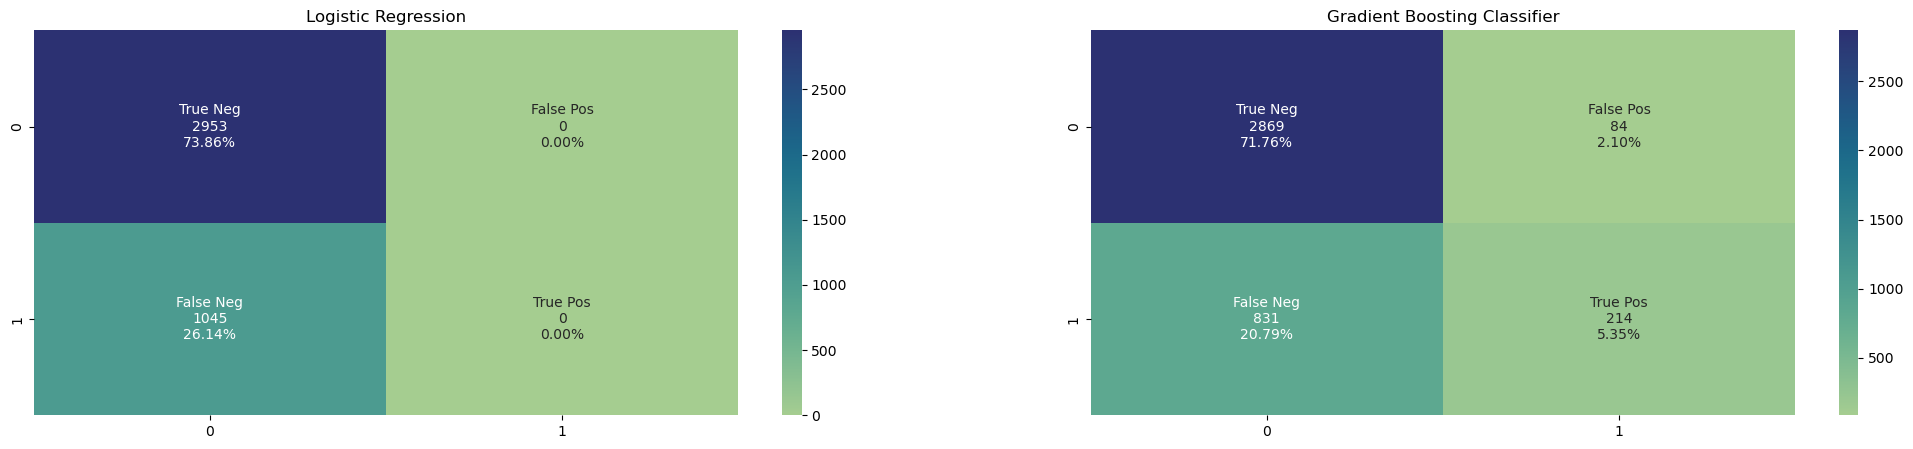

In [20]:
y_pred = []
y_pred.append(y_pred_lr)
y_pred.append(y_pred_gbc)

model_name = ['Logistic Regression', 'Gradient Boosting Classifier']

plt.figure(figsize=(25,5))
for i in range(len(y_pred)):
  plt.subplot(1, 2, i+1)
  cf_matrix = confusion_matrix(y_test, y_pred[i])
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')
  plt.title(model_name[i])
plt.show()

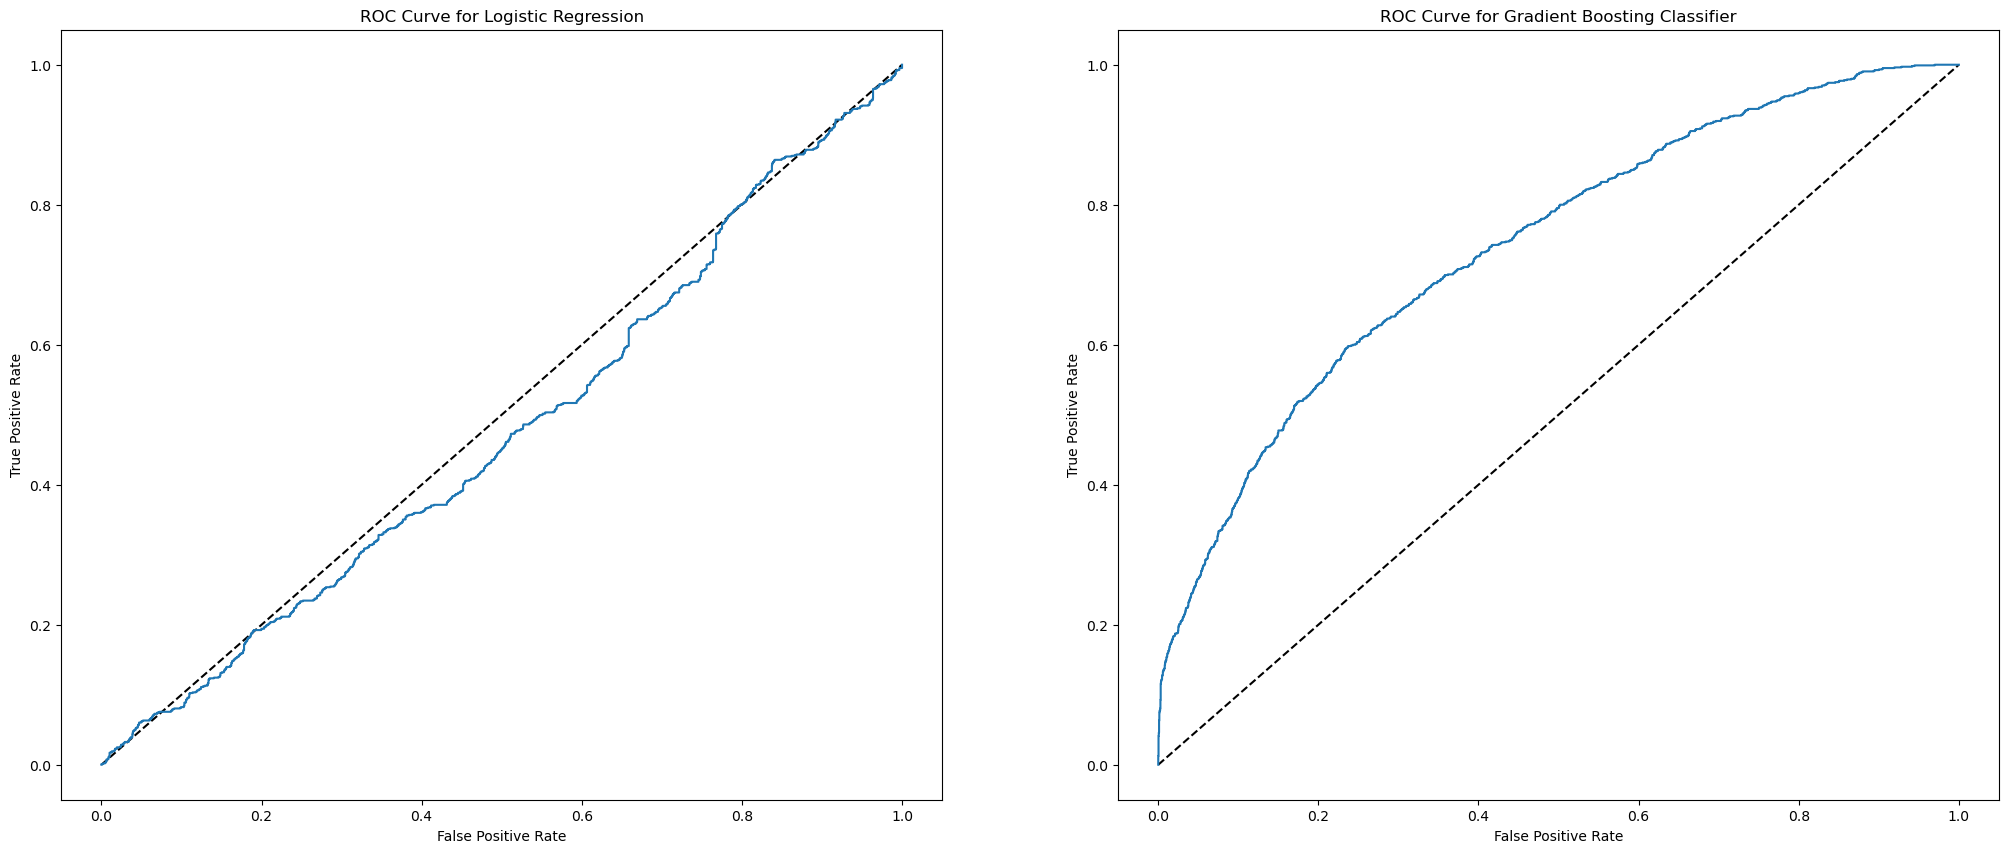

In [21]:
y_pred_prob_lr =lr_model.predict_proba(X_test)[:,1]
y_pred_prob_gbc =gbc_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ =roc_curve(y_test, y_pred_prob_lr)
fpr_gbc, tpr_gbc, _ =roc_curve(y_test, y_pred_prob_gbc)
fpr = []
fpr.append(fpr_lr)
fpr.append(fpr_gbc)
tpr = []
tpr.append(tpr_lr)
tpr.append(tpr_gbc)
plt.figure(figsize=(25,10))
for i in range(len(fpr)):
  plt.subplot(1, 2, i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr[i], tpr[i])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name[i]}')
plt.show()

### Model Performance After Outlier Detection (Isolation Forest)

In [22]:
X = TDCAG.drop(['label'], axis=1)
y = TDCAG.label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [23]:
X_train.shape,y_train.shape

((15992, 91), (15992,))

In [24]:
iso = IsolationForest(contamination=0.05)
X_out = iso.fit_predict(X_train)
mask = (X_out != -1)
X_train, y_train = X_train[mask], y_train[mask]

In [25]:
X_train.shape,y_train.shape

((15192, 91), (15192,))

In [26]:
lr_model = LogisticRegression(max_iter=50000)
with parallel_backend('dask'):
    lr_model.fit(X_train,y_train)
    y_pred_lr = lr_model.predict(X_test)

gbc_model = GradientBoostingClassifier(n_estimators = 50)
with parallel_backend('dask'):
    gbc_model.fit(X_train, y_train)
    y_pred_gbc = gbc_model.predict(X_test)

cv_results_lr = cross_validate(lr_model, X_train, y_train, cv=5, scoring=scoring)
cv_results_gbc = cross_validate(gbc_model, X_train, y_train, cv=5, scoring=scoring)

summary = pd.DataFrame([[cv_results_lr['fit_time'].mean(), cv_results_lr['test_F1'].mean(), cv_results_lr['test_precision'].mean(), cv_results_lr['test_roc_auc'].mean()],
                        [cv_results_gbc['fit_time'].mean(), cv_results_gbc['test_F1'].mean(), cv_results_gbc['test_precision'].mean(), cv_results_gbc['test_roc_auc'].mean()]],
                        columns=['Mean Fit Time', 'Mean F1 Score', 'Mean Precision', 'Mean ROC AUC'], index=['Logistic Regression', 'Gradient Boosting Classifier'])
display(summary.round(2))

Mean Fit Time  Mean F1 Score  Mean Precision  \
Logistic Regression                    0.09           0.00            0.00   
Gradient Boosting Classifier          28.48           0.23            0.68   

                              Mean ROC AUC  
Logistic Regression                   0.47  
Gradient Boosting Classifier          0.72

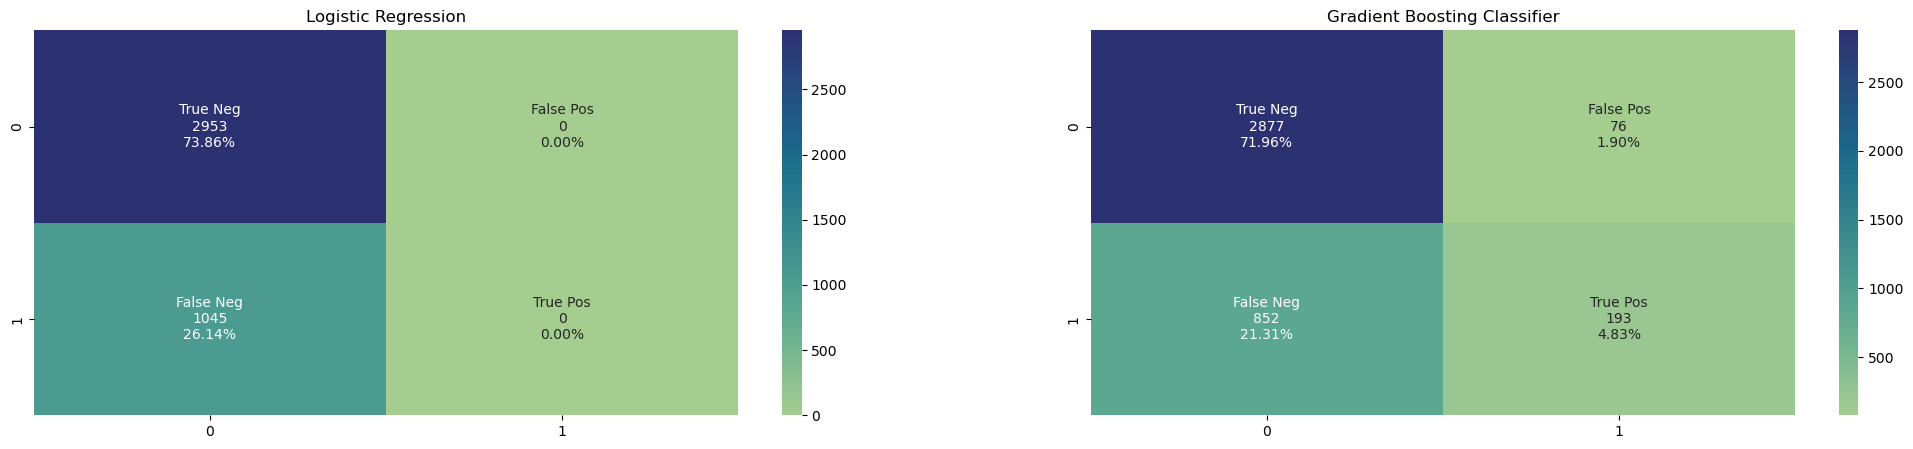

In [27]:
y_pred = []
y_pred.append(y_pred_lr)
y_pred.append(y_pred_gbc)

model_name = ['Logistic Regression', 'Gradient Boosting Classifier']

plt.figure(figsize=(25,5))
for i in range(len(y_pred)):
  plt.subplot(1, 2, i+1)
  cf_matrix = confusion_matrix(y_test, y_pred[i])
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')
  plt.title(model_name[i])
plt.show()

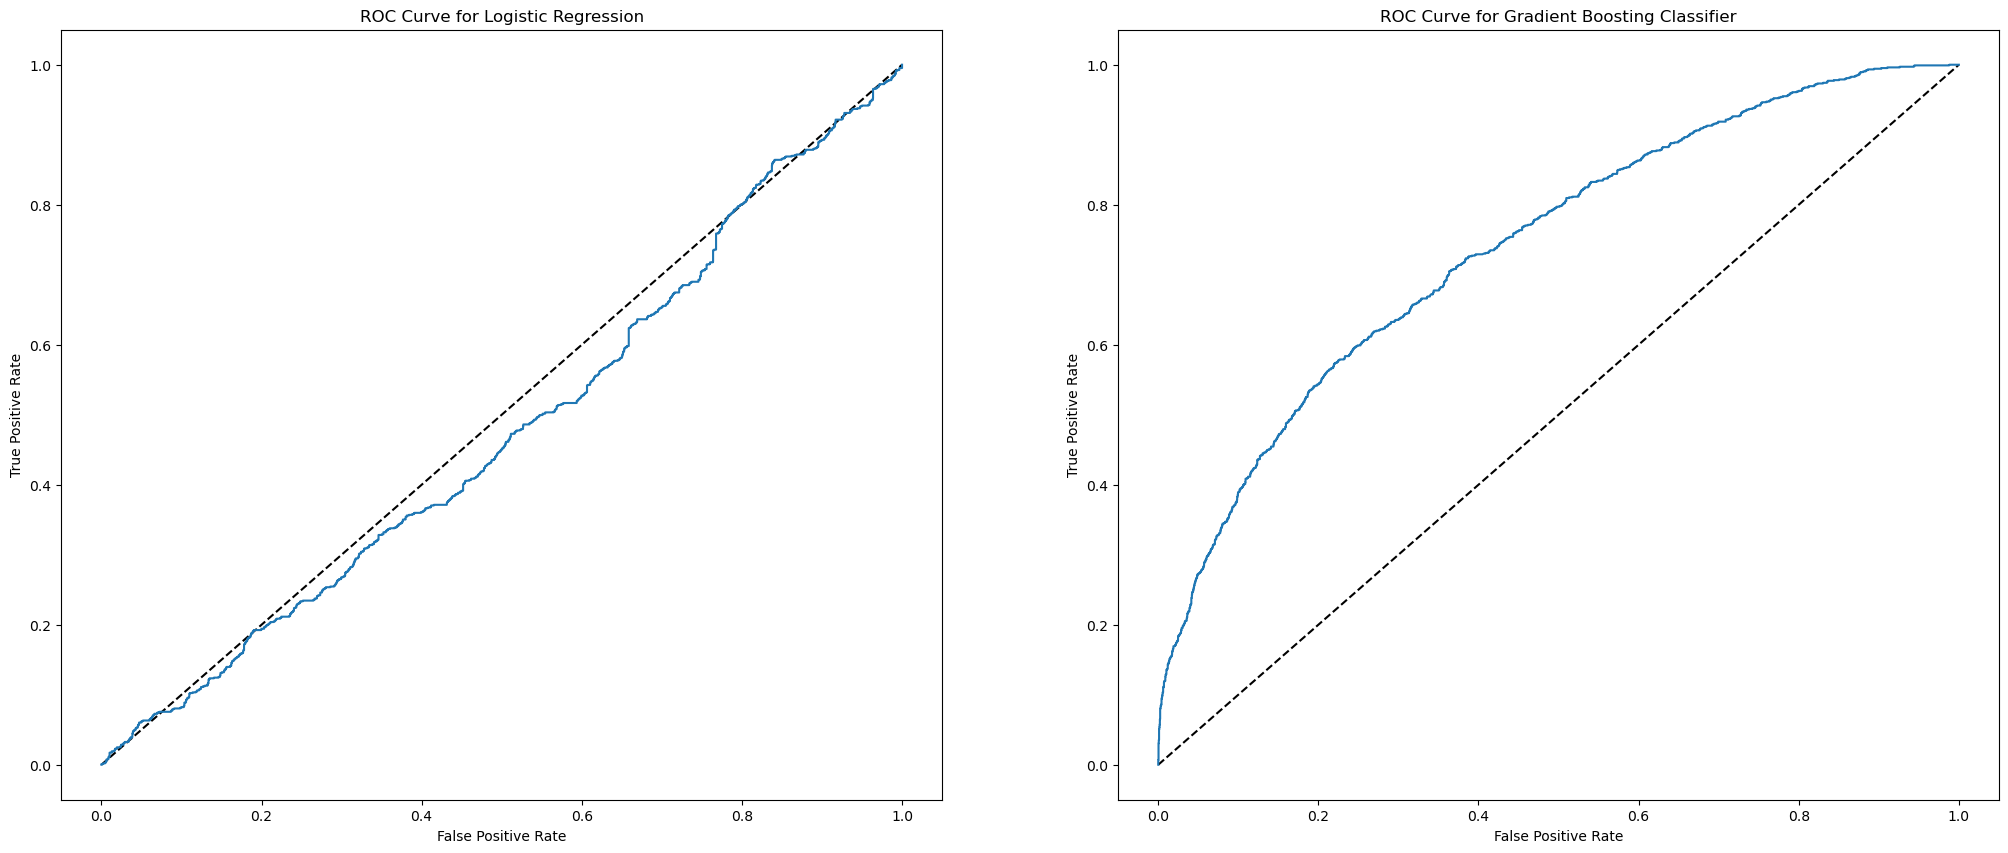

In [28]:
y_pred_prob_lr =lr_model.predict_proba(X_test)[:,1]
y_pred_prob_gbc =gbc_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ =roc_curve(y_test, y_pred_prob_lr)
fpr_gbc, tpr_gbc, _ =roc_curve(y_test, y_pred_prob_gbc)
fpr = []
fpr.append(fpr_lr)
fpr.append(fpr_gbc)
tpr = []
tpr.append(tpr_lr)
tpr.append(tpr_gbc)
plt.figure(figsize=(25,10))
for i in range(len(fpr)):
  plt.subplot(1, 2, i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr[i], tpr[i])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name[i]}')
plt.show()

### Model Performance After Outlier Detection (Local Outlier Factor)

In [29]:
X = TDCAG.drop(['label'], axis=1)
y = TDCAG.label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [30]:
X_train.shape,y_train.shape

((15992, 91), (15992,))

In [31]:
lof = LocalOutlierFactor(contamination=0.05)
X_out = lof.fit_predict(X_train)
mask = (X_out != -1)
X_train, y_train = X_train[mask], y_train[mask]

In [32]:
X_train.shape,y_train.shape

((15192, 91), (15192,))

In [33]:
lr_model = LogisticRegression(max_iter=50000)
with parallel_backend('dask'):
    lr_model.fit(X_train,y_train)
    y_pred_lr = lr_model.predict(X_test)

gbc_model = GradientBoostingClassifier(n_estimators = 50)
with parallel_backend('dask'):
    gbc_model.fit(X_train, y_train)
    y_pred_gbc = gbc_model.predict(X_test)

cv_results_lr = cross_validate(lr_model, X_train, y_train, cv=5, scoring=scoring)
cv_results_gbc = cross_validate(gbc_model, X_train, y_train, cv=5, scoring=scoring)

summary = pd.DataFrame([[cv_results_lr['fit_time'].mean(), cv_results_lr['test_F1'].mean(), cv_results_lr['test_precision'].mean(), cv_results_lr['test_roc_auc'].mean()],
                        [cv_results_gbc['fit_time'].mean(), cv_results_gbc['test_F1'].mean(), cv_results_gbc['test_precision'].mean(), cv_results_gbc['test_roc_auc'].mean()]],
                        columns=['Mean Fit Time', 'Mean F1 Score', 'Mean Precision', 'Mean ROC AUC'], index=['Logistic Regression', 'Gradient Boosting Classifier'])
display(summary.round(2))

Mean Fit Time  Mean F1 Score  Mean Precision  \
Logistic Regression                    0.09            0.0            0.00   
Gradient Boosting Classifier          21.78            0.3            0.72   

                              Mean ROC AUC  
Logistic Regression                   0.48  
Gradient Boosting Classifier          0.74

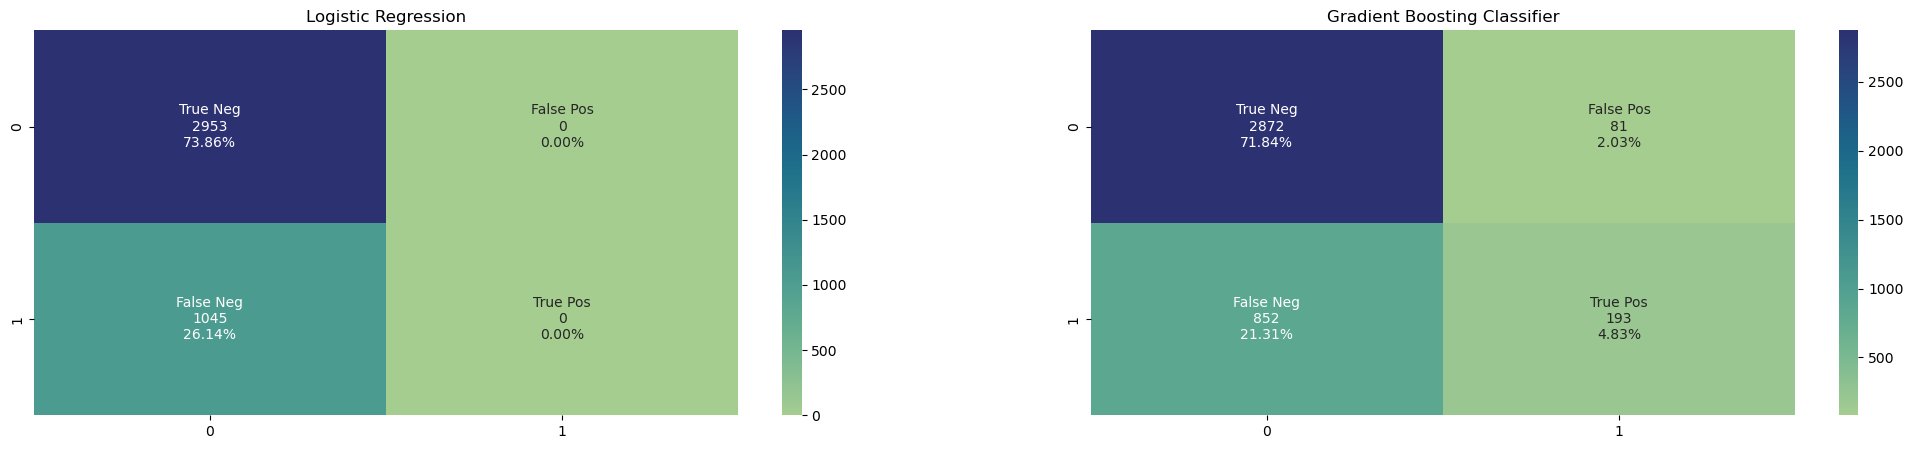

In [34]:
y_pred = []
y_pred.append(y_pred_lr)
y_pred.append(y_pred_gbc)

model_name = ['Logistic Regression', 'Gradient Boosting Classifier']

plt.figure(figsize=(25,5))
for i in range(len(y_pred)):
  plt.subplot(1, 2, i+1)
  cf_matrix = confusion_matrix(y_test, y_pred[i])
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')
  plt.title(model_name[i])
plt.show()

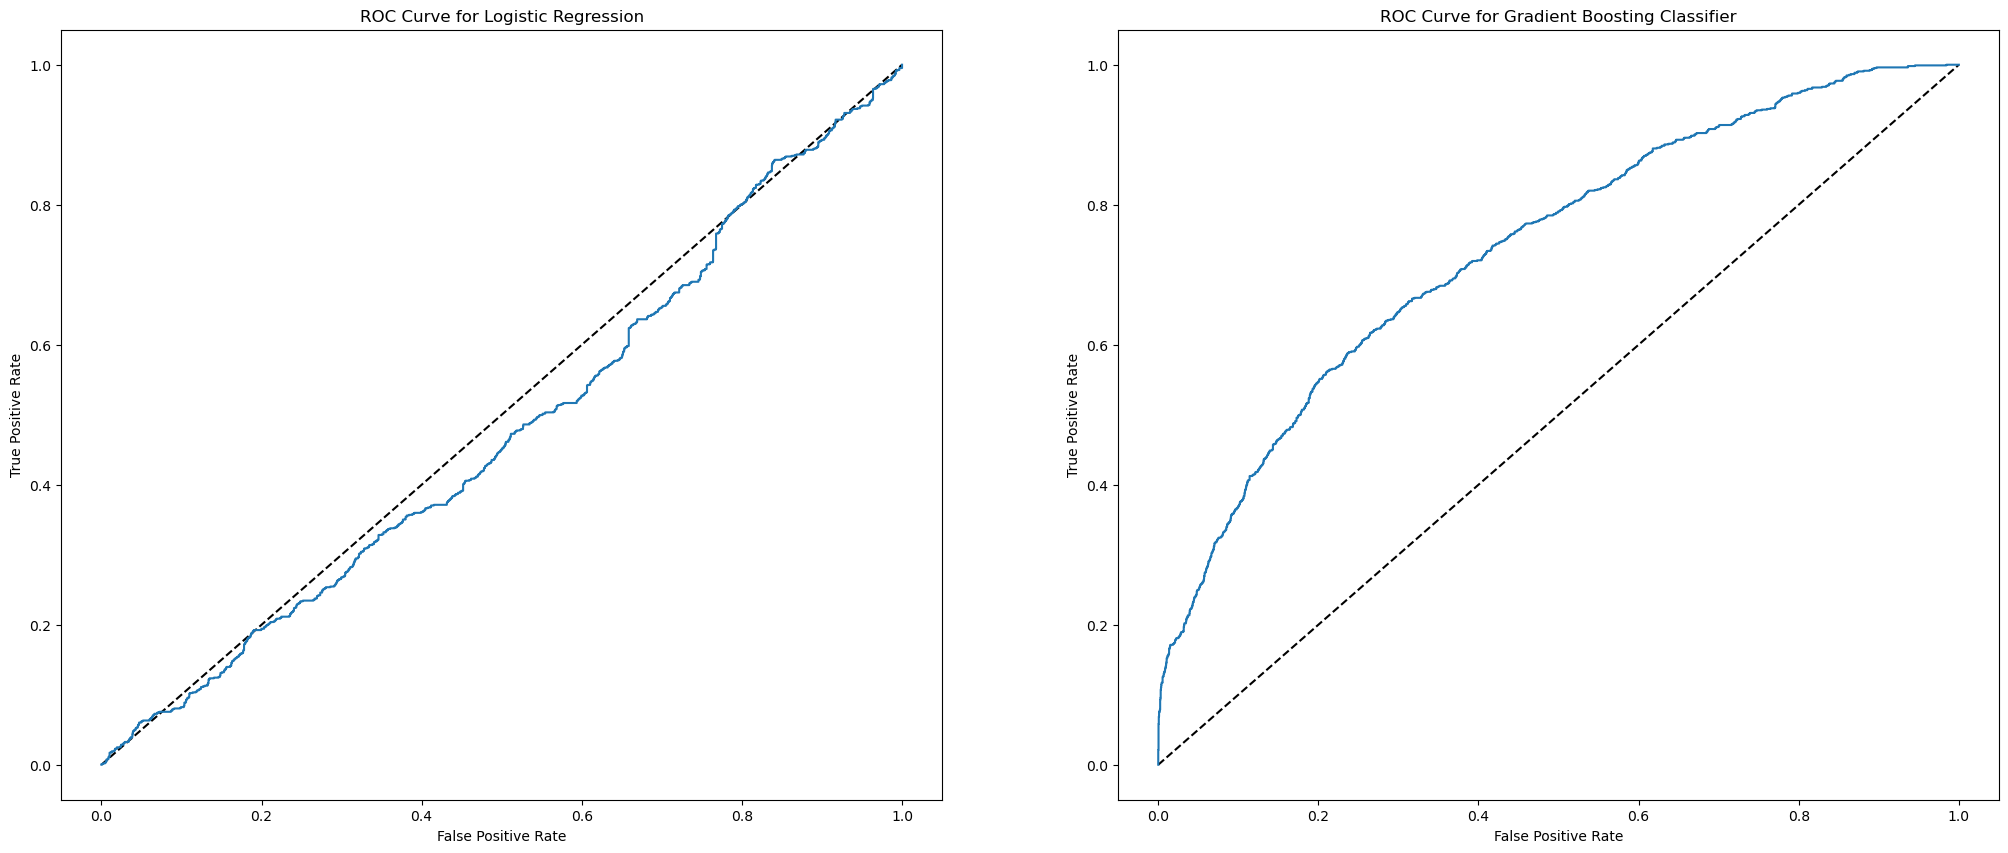

In [35]:
y_pred_prob_lr =lr_model.predict_proba(X_test)[:,1]
y_pred_prob_gbc =gbc_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ =roc_curve(y_test, y_pred_prob_lr)
fpr_gbc, tpr_gbc, _ =roc_curve(y_test, y_pred_prob_gbc)
fpr = []
fpr.append(fpr_lr)
fpr.append(fpr_gbc)
tpr = []
tpr.append(tpr_lr)
tpr.append(tpr_gbc)
plt.figure(figsize=(25,10))
for i in range(len(fpr)):
  plt.subplot(1, 2, i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr[i], tpr[i])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name[i]}')
plt.show()

### Model Performance After Outlier Detection (One-Class SVM)

In [36]:
X = TDCAG.drop(['label'], axis=1)
y = TDCAG.label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [37]:
X_train.shape,y_train.shape

((15992, 91), (15992,))

In [38]:
svm = OneClassSVM(nu=0.05)
X_out = svm.fit_predict(X_train)
mask = (X_out != -1)
X_train, y_train = X_train[mask], y_train[mask]

In [39]:
X_train.shape,y_train.shape

((15304, 91), (15304,))

In [40]:
lr_model = LogisticRegression(max_iter=50000)
with parallel_backend('dask'):
    lr_model.fit(X_train,y_train)
    y_pred_lr = lr_model.predict(X_test)

gbc_model = GradientBoostingClassifier(n_estimators = 50)
with parallel_backend('dask'):
    gbc_model.fit(X_train, y_train)
    y_pred_gbc = gbc_model.predict(X_test)

cv_results_lr = cross_validate(lr_model, X_train, y_train, cv=5, scoring=scoring)
cv_results_gbc = cross_validate(gbc_model, X_train, y_train, cv=5, scoring=scoring)

summary = pd.DataFrame([[cv_results_lr['fit_time'].mean(), cv_results_lr['test_F1'].mean(), cv_results_lr['test_precision'].mean(), cv_results_lr['test_roc_auc'].mean()],
                        [cv_results_gbc['fit_time'].mean(), cv_results_gbc['test_F1'].mean(), cv_results_gbc['test_precision'].mean(), cv_results_gbc['test_roc_auc'].mean()]],
                        columns=['Mean Fit Time', 'Mean F1 Score', 'Mean Precision', 'Mean ROC AUC'], index=['Logistic Regression', 'Gradient Boosting Classifier'])
display(summary.round(2))

Mean Fit Time  Mean F1 Score  Mean Precision  \
Logistic Regression                    0.12           0.00            0.00   
Gradient Boosting Classifier          23.89           0.32            0.72   

                              Mean ROC AUC  
Logistic Regression                   0.47  
Gradient Boosting Classifier          0.74

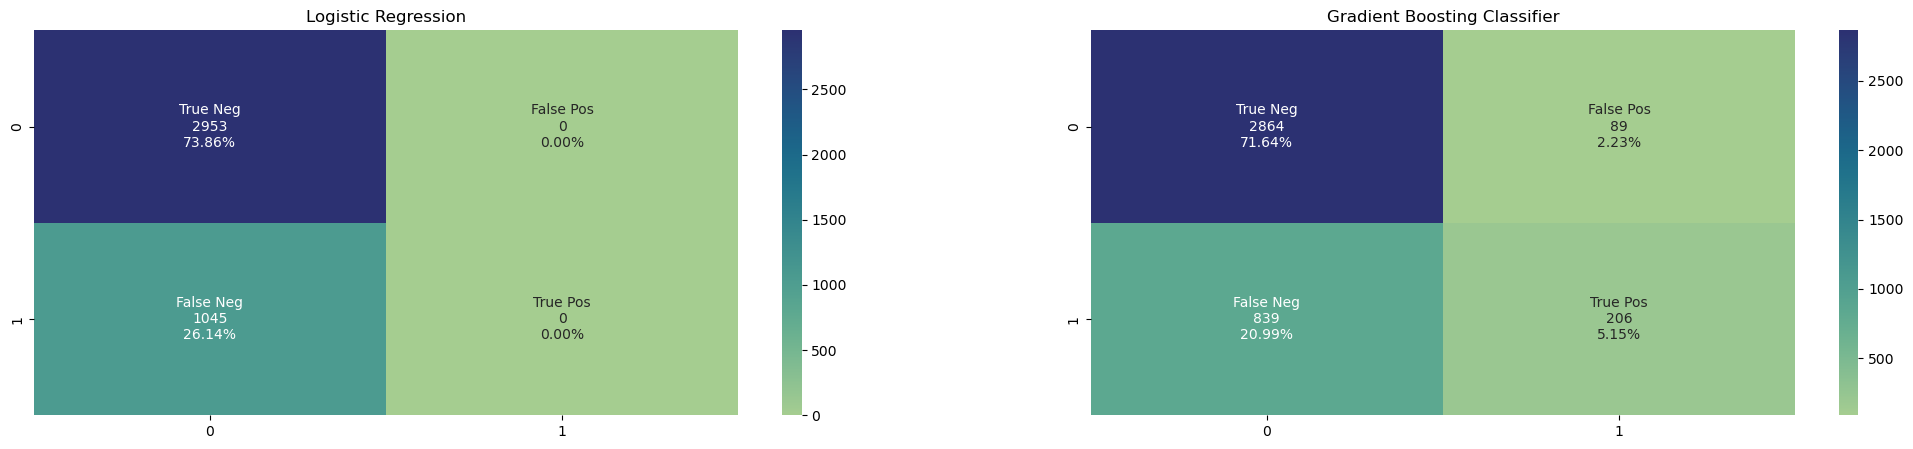

In [41]:
y_pred = []
y_pred.append(y_pred_lr)
y_pred.append(y_pred_gbc)

model_name = ['Logistic Regression', 'Gradient Boosting Classifier']

plt.figure(figsize=(25,5))
for i in range(len(y_pred)):
  plt.subplot(1, 2, i+1)
  cf_matrix = confusion_matrix(y_test, y_pred[i])
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')
  plt.title(model_name[i])
plt.show()

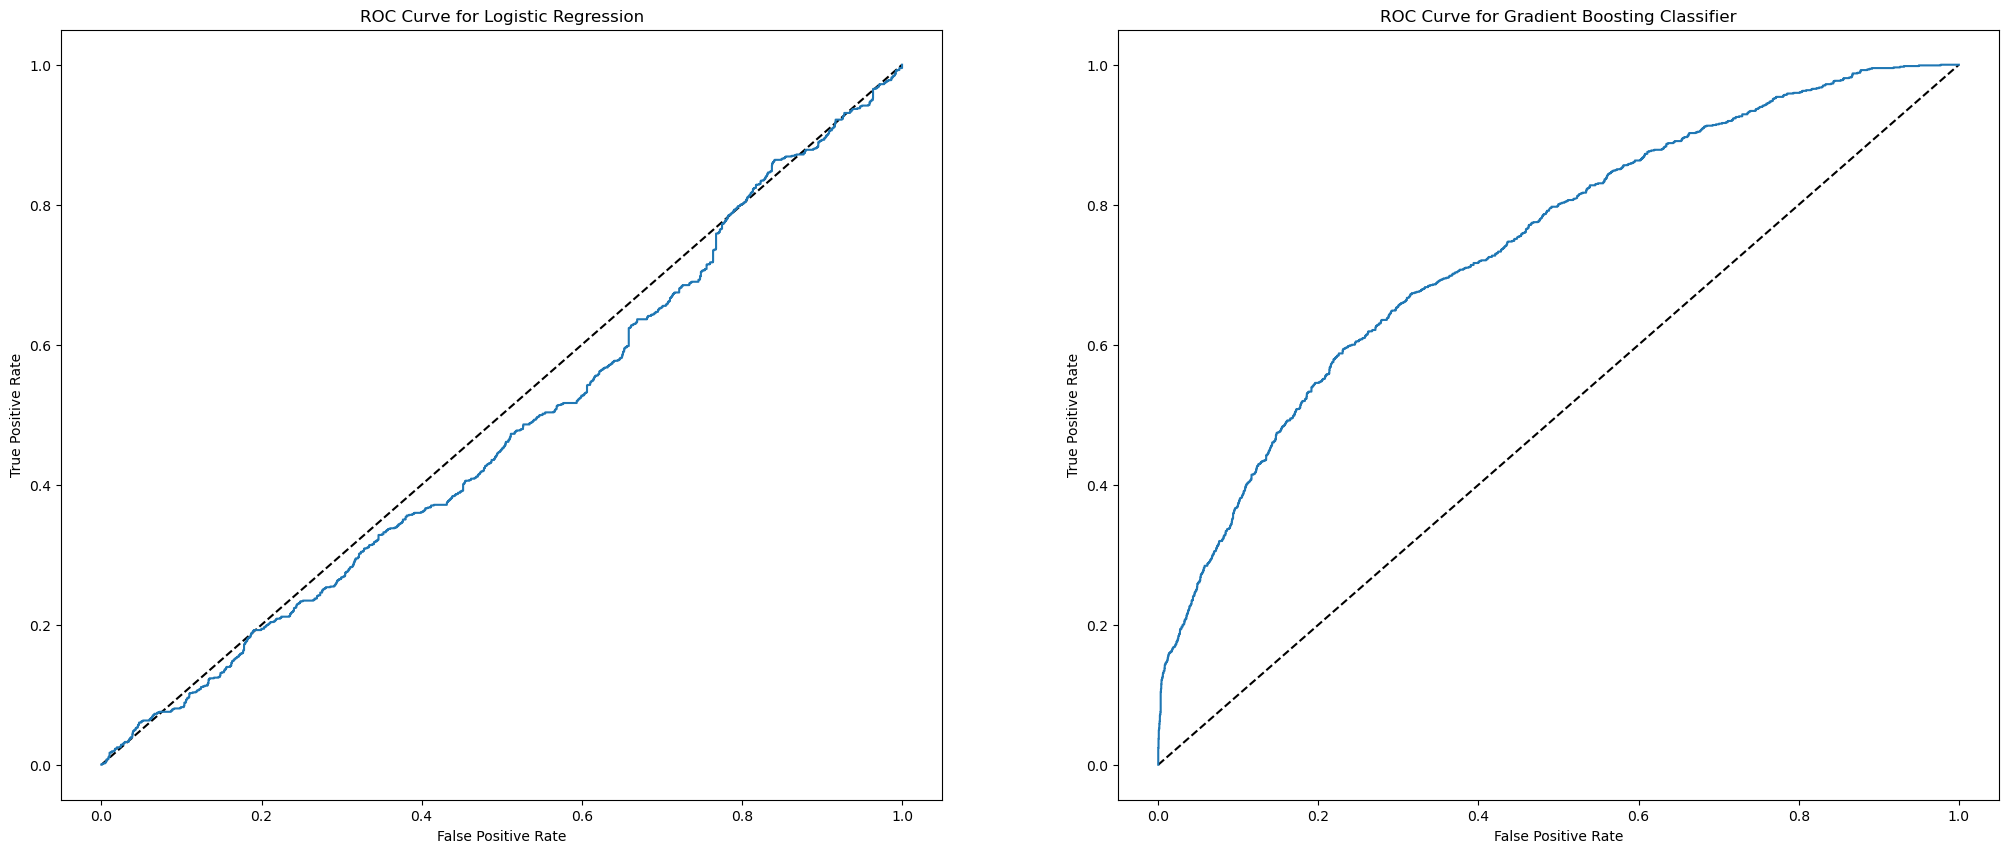

In [42]:
y_pred_prob_lr =lr_model.predict_proba(X_test)[:,1]
y_pred_prob_gbc =gbc_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ =roc_curve(y_test, y_pred_prob_lr)
fpr_gbc, tpr_gbc, _ =roc_curve(y_test, y_pred_prob_gbc)
fpr = []
fpr.append(fpr_lr)
fpr.append(fpr_gbc)
tpr = []
tpr.append(tpr_lr)
tpr.append(tpr_gbc)
plt.figure(figsize=(25,10))
for i in range(len(fpr)):
  plt.subplot(1, 2, i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr[i], tpr[i])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name[i]}')
plt.show()

### Model Performance After Outlier Detection (Minimum Covariance Determinant)

In [43]:
X = TDCAG.drop(['label'], axis=1)
y = TDCAG.label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [44]:
X_train.shape,y_train.shape

((15992, 91), (15992,))

In [45]:
ee = EllipticEnvelope(contamination=0.05)
X_out = ee.fit_predict(X_train)
mask = (X_out != -1)
X_train, y_train = X_train[mask], y_train[mask]

In [46]:
X_train.shape,y_train.shape

((15192, 91), (15192,))

In [47]:
lr_model = LogisticRegression(max_iter=50000)
with parallel_backend('dask'):
    lr_model.fit(X_train,y_train)
    y_pred_lr = lr_model.predict(X_test)

gbc_model = GradientBoostingClassifier(n_estimators = 50)
with parallel_backend('dask'):
    gbc_model.fit(X_train, y_train)
    y_pred_gbc = gbc_model.predict(X_test)

cv_results_lr = cross_validate(lr_model, X_train, y_train, cv=5, scoring=scoring)
cv_results_gbc = cross_validate(gbc_model, X_train, y_train, cv=5, scoring=scoring)

summary = pd.DataFrame([[cv_results_lr['fit_time'].mean(), cv_results_lr['test_F1'].mean(), cv_results_lr['test_precision'].mean(), cv_results_lr['test_roc_auc'].mean()],
                        [cv_results_gbc['fit_time'].mean(), cv_results_gbc['test_F1'].mean(), cv_results_gbc['test_precision'].mean(), cv_results_gbc['test_roc_auc'].mean()]],
                        columns=['Mean Fit Time', 'Mean F1 Score', 'Mean Precision', 'Mean ROC AUC'], index=['Logistic Regression', 'Gradient Boosting Classifier'])
display(summary.round(2))

Mean Fit Time  Mean F1 Score  Mean Precision  \
Logistic Regression                    0.09            0.0            0.00   
Gradient Boosting Classifier          17.59            0.3            0.71   

                              Mean ROC AUC  
Logistic Regression                   0.48  
Gradient Boosting Classifier          0.74

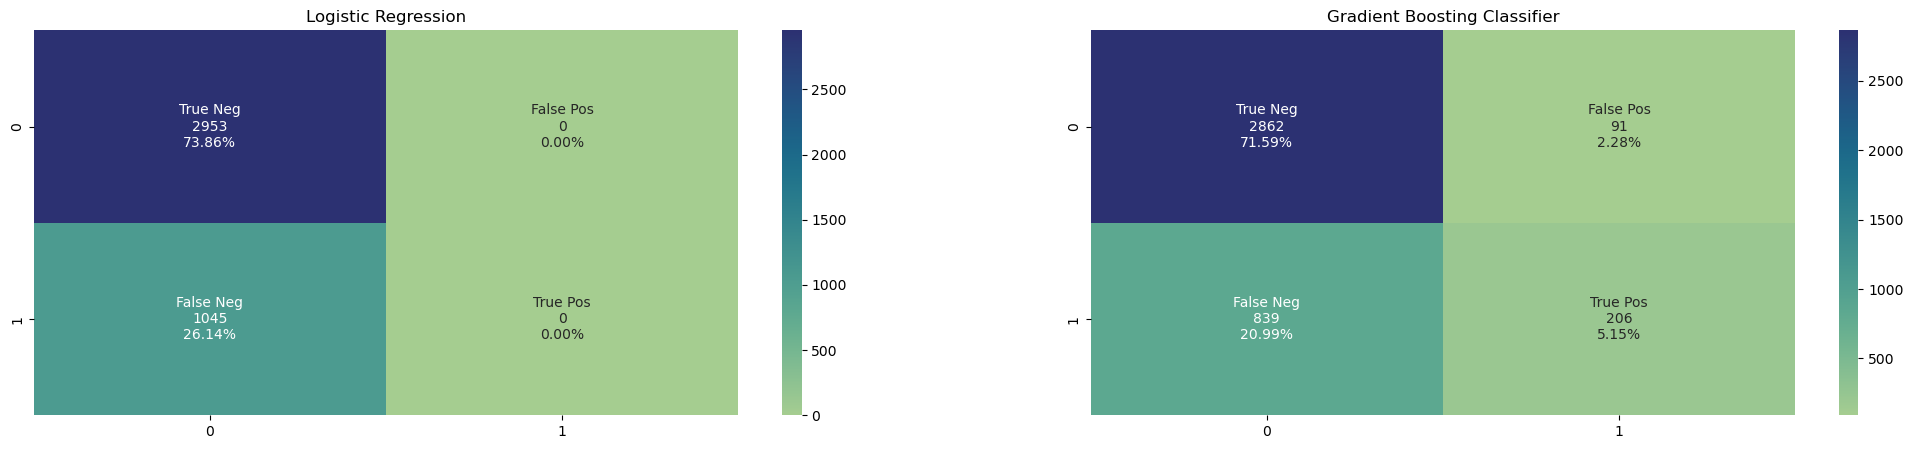

In [48]:
y_pred = []
y_pred.append(y_pred_lr)
y_pred.append(y_pred_gbc)

model_name = ['Logistic Regression', 'Gradient Boosting Classifier']

plt.figure(figsize=(25,5))
for i in range(len(y_pred)):
  plt.subplot(1, 2, i+1)
  cf_matrix = confusion_matrix(y_test, y_pred[i])
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')
  plt.title(model_name[i])
plt.show()

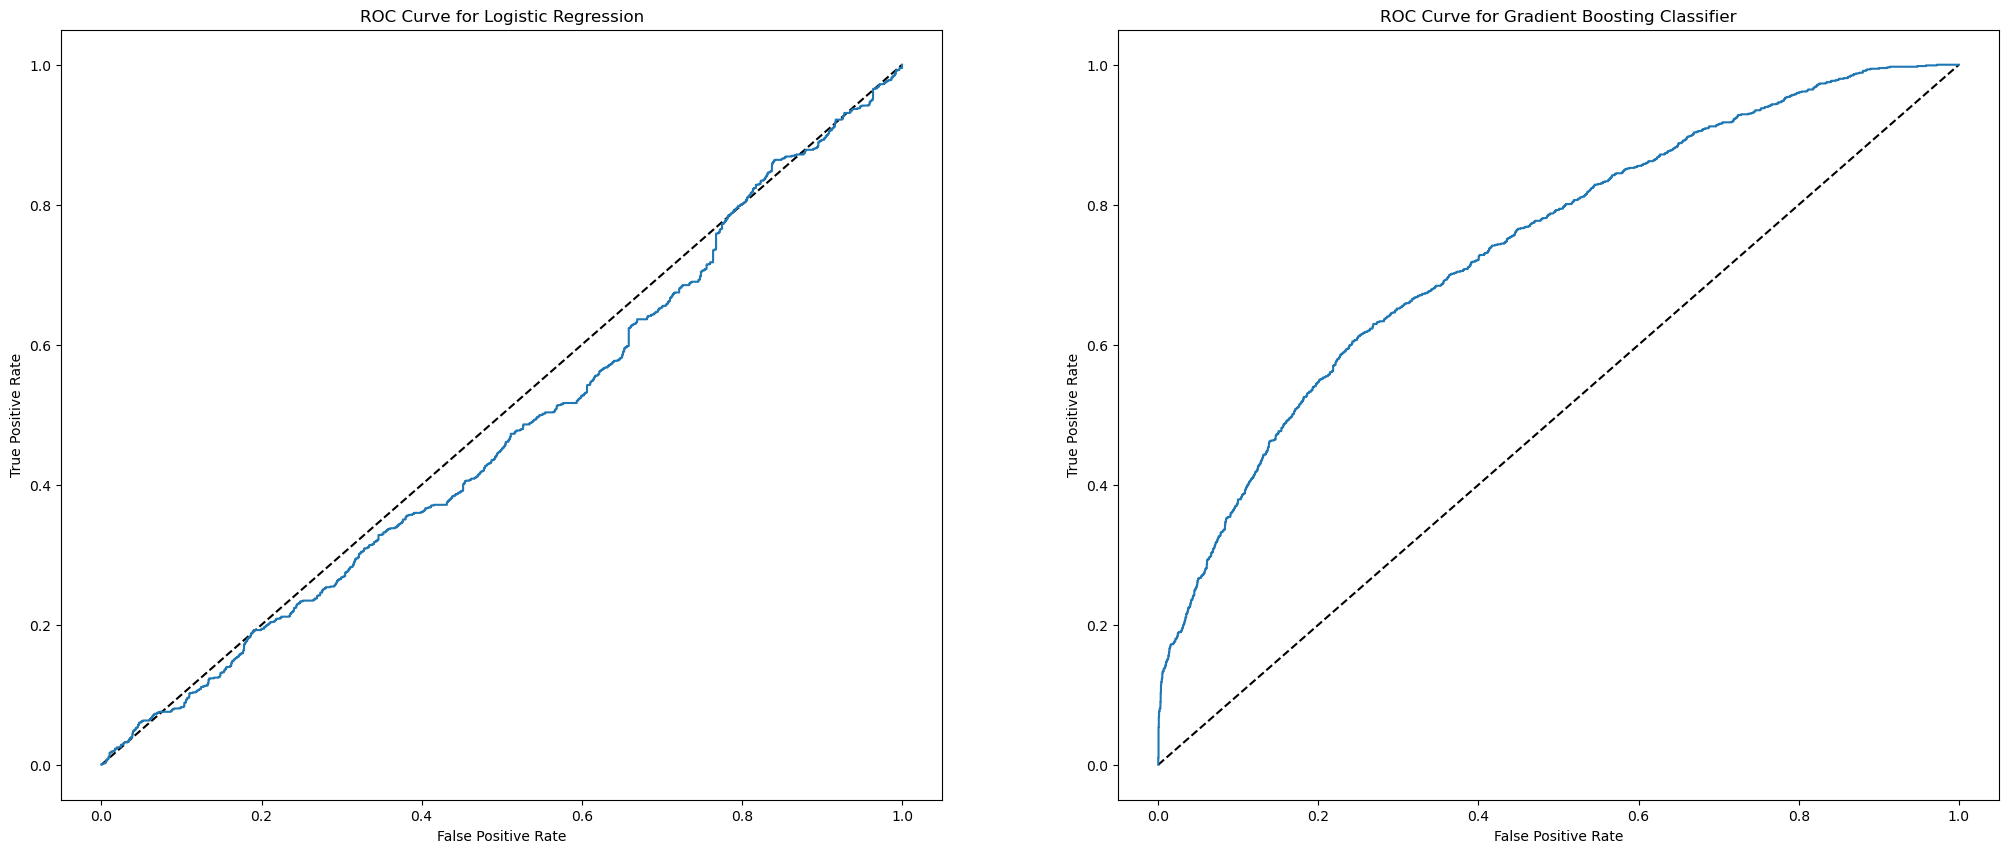

2023-01-29 12:12:02,052 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:57319', name: 0, status: running, memory: 0, processing: 0>
2023-01-29 12:12:02,309 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:57325', name: 2, status: running, memory: 0, processing: 0>
2023-01-29 12:12:02,336 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:57319'.
2023-01-29 12:12:02,340 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:57325'.
2023-01-29 12:12:05,587 - distributed.nanny - WARNING - Restarting worker
2023-01-29 12:12:05,603 - distributed.nanny - WARNING - Restarting worker


In [49]:
y_pred_prob_lr =lr_model.predict_proba(X_test)[:,1]
y_pred_prob_gbc =gbc_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ =roc_curve(y_test, y_pred_prob_lr)
fpr_gbc, tpr_gbc, _ =roc_curve(y_test, y_pred_prob_gbc)
fpr = []
fpr.append(fpr_lr)
fpr.append(fpr_gbc)
tpr = []
tpr.append(tpr_lr)
tpr.append(tpr_gbc)
plt.figure(figsize=(25,10))
for i in range(len(fpr)):
  plt.subplot(1, 2, i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr[i], tpr[i])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name[i]}')
plt.show()

### Model Performance After Outlier Detection (Robust Covariance Detection)

In [50]:
X = TDCAG.drop(['label'], axis=1)
y = TDCAG.label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [51]:
X_train.shape,y_train.shape

((15992, 91), (15992,))

In [52]:
rc = EllipticEnvelope(support_fraction=0.994,contamination=0.05)
X_out = rc.fit_predict(X_train)
mask = (X_out != -1)
X_train, y_train = X_train[mask], y_train[mask]

In [53]:
X_train.shape,y_train.shape

((15192, 91), (15192,))

In [54]:
lr_model = LogisticRegression(max_iter=50000)
with parallel_backend('dask'):
    lr_model.fit(X_train,y_train)
    y_pred_lr = lr_model.predict(X_test)

gbc_model = GradientBoostingClassifier(n_estimators = 50)
with parallel_backend('dask'):
    gbc_model.fit(X_train, y_train)
    y_pred_gbc = gbc_model.predict(X_test)

cv_results_lr = cross_validate(lr_model, X_train, y_train, cv=5, scoring=scoring)
cv_results_gbc = cross_validate(gbc_model, X_train, y_train, cv=5, scoring=scoring)

summary = pd.DataFrame([[cv_results_lr['fit_time'].mean(), cv_results_lr['test_F1'].mean(), cv_results_lr['test_precision'].mean(), cv_results_lr['test_roc_auc'].mean()],
                        [cv_results_gbc['fit_time'].mean(), cv_results_gbc['test_F1'].mean(), cv_results_gbc['test_precision'].mean(), cv_results_gbc['test_roc_auc'].mean()]],
                        columns=['Mean Fit Time', 'Mean F1 Score', 'Mean Precision', 'Mean ROC AUC'], index=['Logistic Regression', 'Gradient Boosting Classifier'])
display(summary.round(2))

Mean Fit Time  Mean F1 Score  Mean Precision  \
Logistic Regression                    0.07            0.0            0.00   
Gradient Boosting Classifier          17.26            0.3            0.72   

                              Mean ROC AUC  
Logistic Regression                   0.48  
Gradient Boosting Classifier          0.74

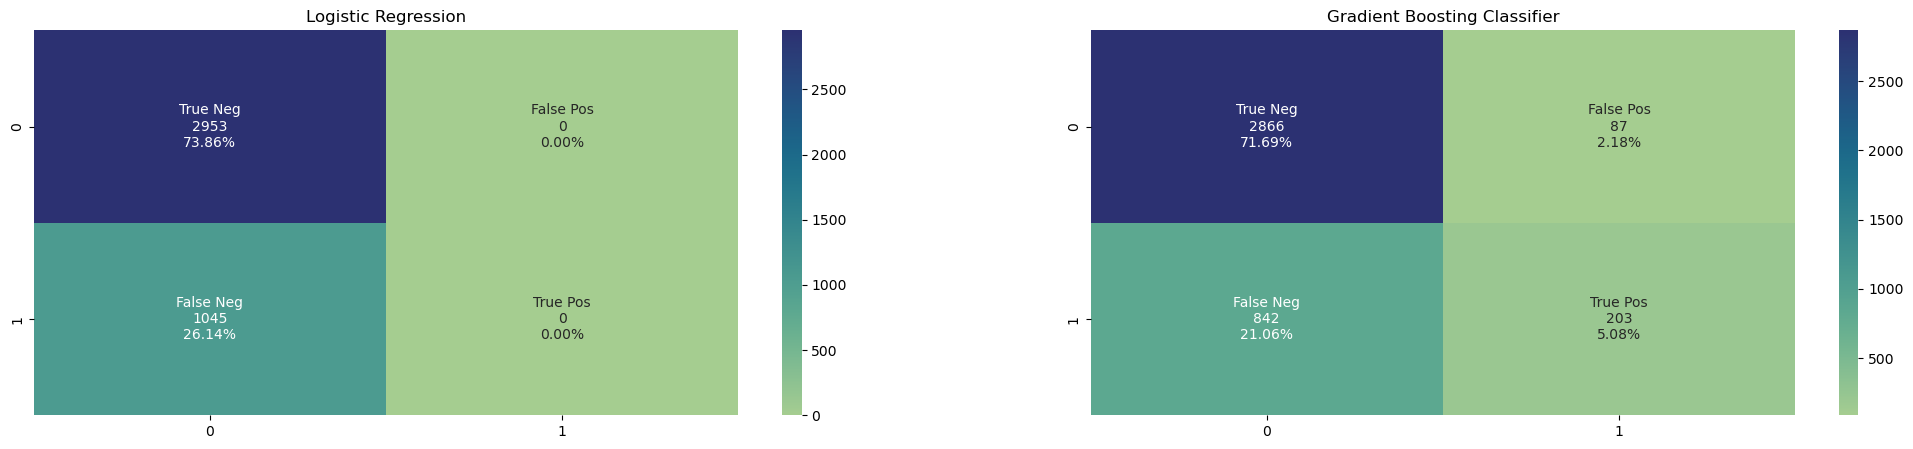

In [55]:
y_pred = []
y_pred.append(y_pred_lr)
y_pred.append(y_pred_gbc)

model_name = ['Logistic Regression', 'Gradient Boosting Classifier']

plt.figure(figsize=(25,5))
for i in range(len(y_pred)):
  plt.subplot(1, 2, i+1)
  cf_matrix = confusion_matrix(y_test, y_pred[i])
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')
  plt.title(model_name[i])
plt.show()

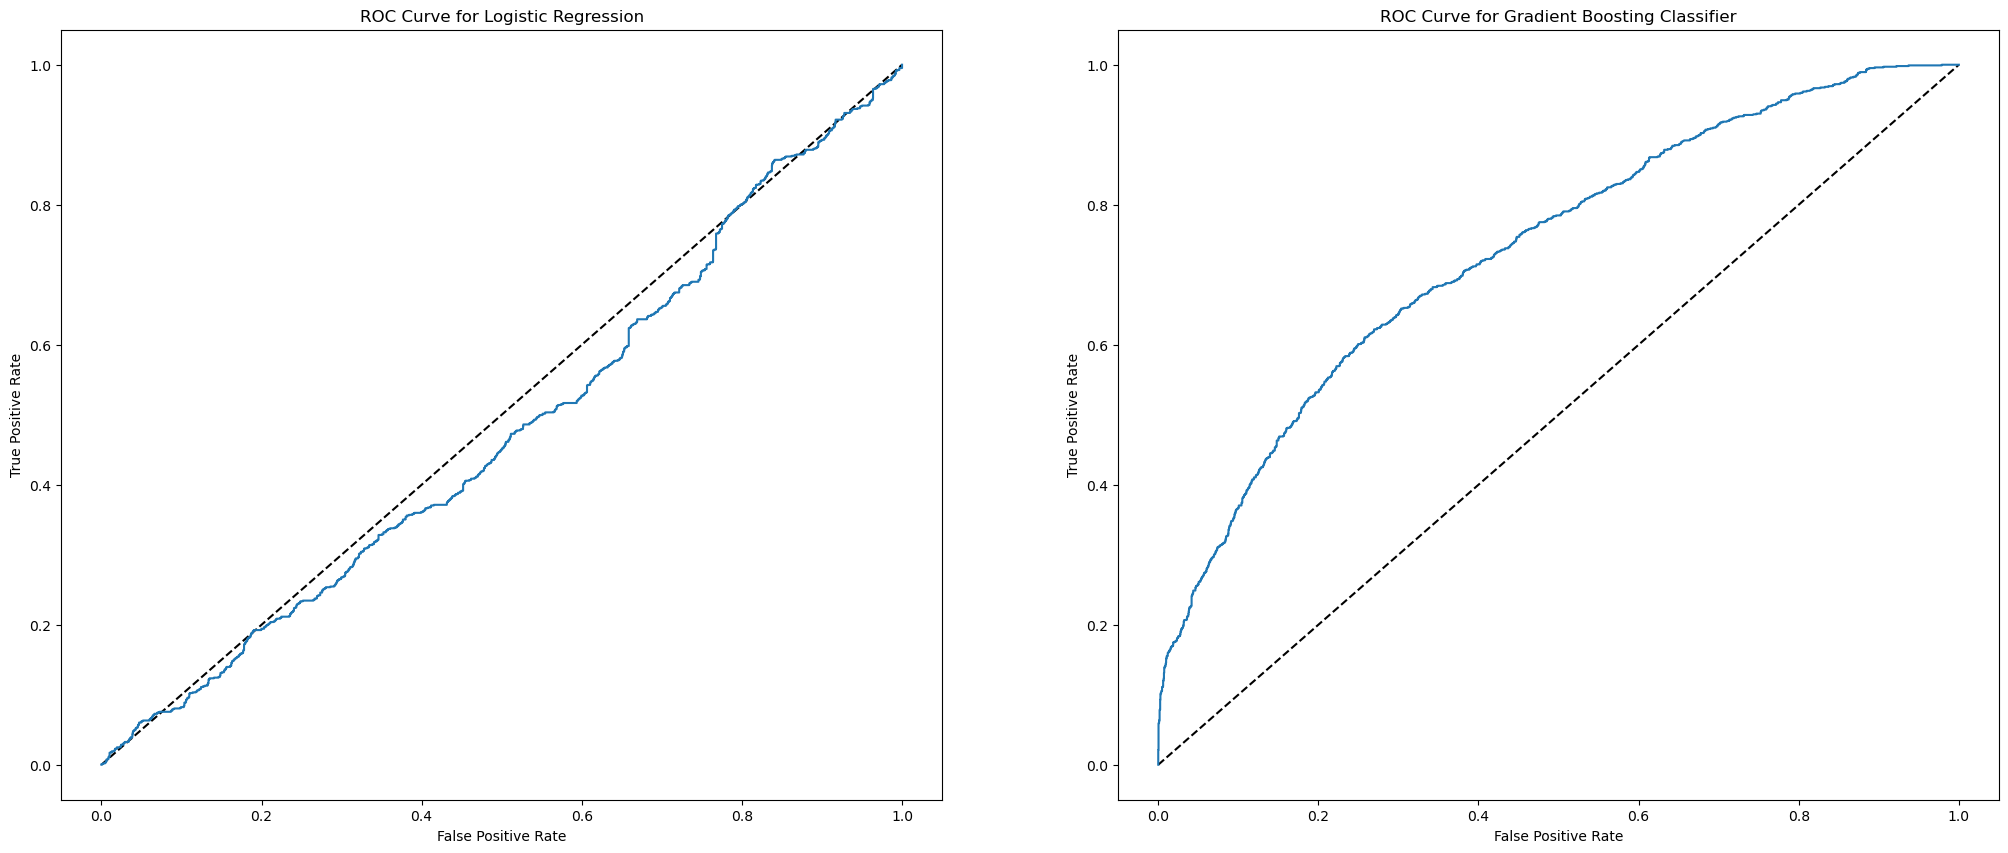

In [56]:
y_pred_prob_lr =lr_model.predict_proba(X_test)[:,1]
y_pred_prob_gbc =gbc_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ =roc_curve(y_test, y_pred_prob_lr)
fpr_gbc, tpr_gbc, _ =roc_curve(y_test, y_pred_prob_gbc)
fpr = []
fpr.append(fpr_lr)
fpr.append(fpr_gbc)
tpr = []
tpr.append(tpr_lr)
tpr.append(tpr_gbc)
plt.figure(figsize=(25,10))
for i in range(len(fpr)):
  plt.subplot(1, 2, i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr[i], tpr[i])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name[i]}')
plt.show()

### RESULTS

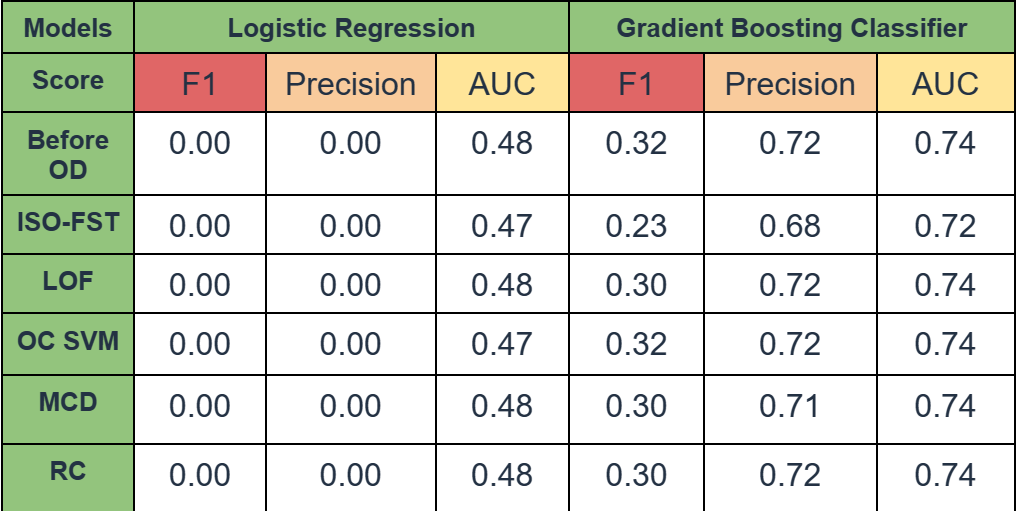